In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2024-12-06 13:34:41.361656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733459681.372891 2122570 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733459681.376300 2122570 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 13:34:41.387963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found GPU at: /device:GPU:0


I0000 00:00:1733459683.217722 2122570 gpu_device.cc:2022] Created device /device:GPU:0 with 1077 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:23:00.0, compute capability: 8.6


In [2]:
import os
import cv2
import pandas as pd

In [3]:
from PIL import Image
def create_df(data_path):
    """
         이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    df = pd.DataFrame({})
    data_dir_list = os.listdir(data_path)
    print(data_dir_list)
    for i in range(len(data_dir_list)):
      file_list = os.listdir(data_path + "/" + data_dir_list[i])
      img_path_list = []
      for j in range(len(file_list)):
        img_path = data_path + "/" + data_dir_list[i] + "/" +file_list[j]
        try:
          image = Image.open(img_path)
          image.verify()
          img_path_list.append(img_path)
        except:
          print(img_path)
          pass
      df = pd.concat([df,pd.DataFrame({'File_path':img_path_list,'Label':data_dir_list[i]})])
      print(data_dir_list[i],len(file_list))

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return df

In [4]:
df = create_df('dataset/train')

['hh', 'cse', 'wb', 'wjj', 'rg']
hh 752
cse 1159
wb 1028
wjj 1053
rg 1036


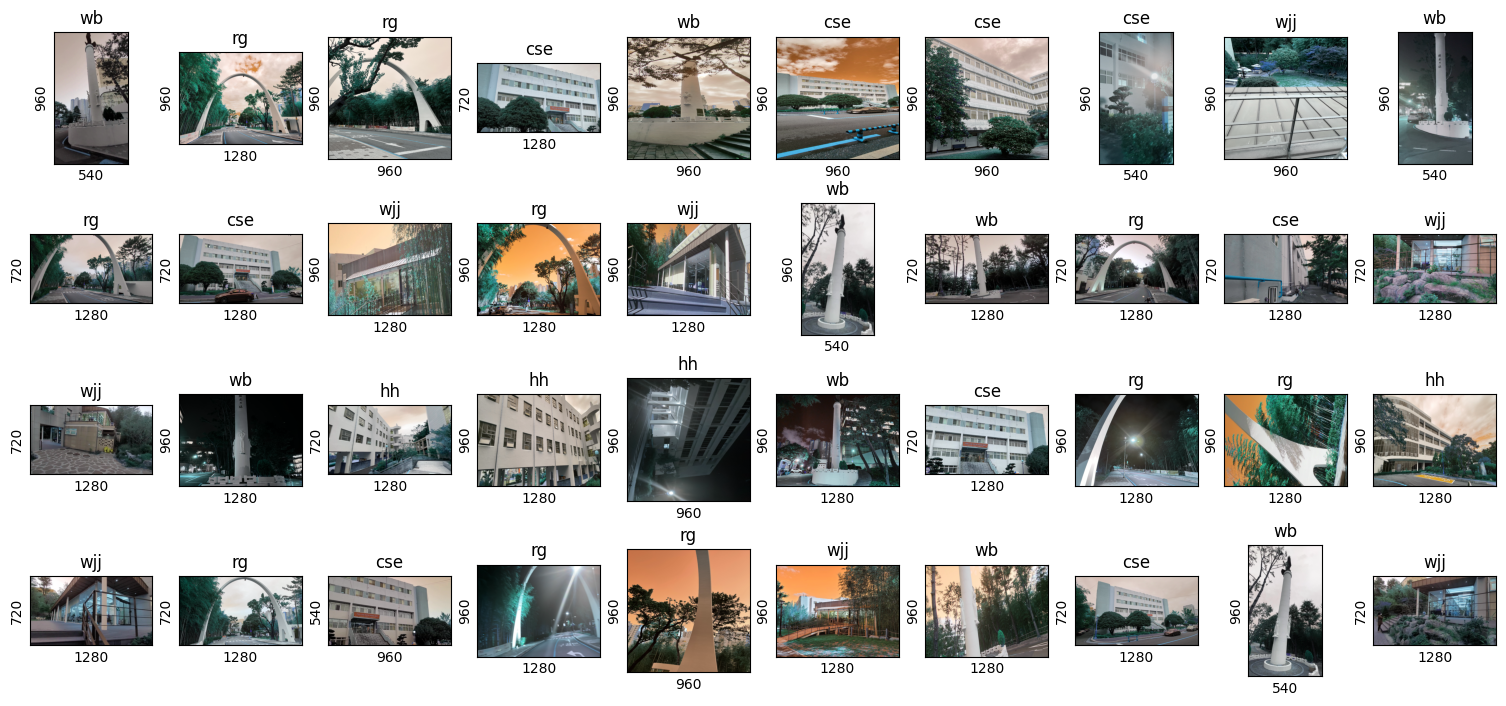

In [5]:
import matplotlib.pyplot as plt
"""
  데이터 확인(이미지 라벨, 가로크기,세로크기)
"""
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = cv2.imread(df.File_path[i])
    ax.imshow(img)
    ax.set_title(df.Label[i], fontsize = 12)
    ax.set_xlabel(img.shape[1], fontsize=10)
    ax.set_ylabel(img.shape[0], fontsize=10)
plt.tight_layout(pad=0.5)
plt.show()

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# 훈련데이터 및 검증데이터 분리, 9:1, 계층샘플링
train_df, val_df = train_test_split(df, test_size=0.1, random_state=0, stratify=df.Label)
print(train_df.shape, val_df.shape)

# 테스트 데이터 로드
test_df = create_df('dataset/test')

(4525, 2) (503, 2)
['hh', 'cse', 'wb', 'wjj', 'rg']
hh 88
cse 126
wb 113
wjj 124
rg 113


In [7]:
import numpy as np
import tensorflow as tf
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    val_images = val_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    
    return train_generator,val_generator,test_generator,train_images,val_images,test_images


In [8]:
train_generator, val_generator, test_generator, train_images, val_images, test_images = create_gen()

Found 4525 validated image filenames belonging to 5 classes.
Found 503 validated image filenames belonging to 5 classes.
Found 564 validated image filenames belonging to 5 classes.


In [12]:
"""
랜덤 시드 고정
"""
import random
def fix_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
"""
모델링
"""
def get_model(model):
    # Load the pretained model
    kwargs =    {'input_shape':(150, 150, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False# 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    tuning_layer_name = 'conv5_block1_preact_bn'
    tuning_layer = pretrained_model.get_layer(tuning_layer_name)
    tuning_index = pretrained_model.layers.index(tuning_layer)

    for layer in pretrained_model.layers[tuning_index:]:
        layer.trainable = True
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Flatten()(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    # 라벨 개수가 5개이기 때문에 Dencs도 5로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/epoch-{epoch}-val_loss-{val_loss:.4f}-val_acc-{val_accuracy:.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)
fix_seed(0)
model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=10,verbose=1,callbacks=[model_checkpoint])

Epoch 1/10


I0000 00:00:1733459974.815152 2125332 service.cc:148] XLA service 0x7f4d04002410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733459974.815195 2125332 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-12-06 13:39:35.006194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733459976.037883 2125332 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/71 ━━━━━━━━━━━━━━━━━━━━ 17:24 15s/step - accuracy: 0.2031 - loss: 2.3805

I0000 00:00:1733459982.449217 2125332 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 3/71 ━━━━━━━━━━━━━━━━━━━━ 40s 599ms/step - accuracy: 0.3168 - loss: 1.9954

2024-12-06 13:39:47.417804: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7951 - loss: 0.5906

2024-12-06 13:41:12.373854: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1541', 192 bytes spill stores, 512 bytes spill loads

2024-12-06 13:41:20.767260: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1541', 4 bytes spill stores, 4 bytes spill loads

2024-12-06 13:41:20.795247: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1541_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:41:20.957486: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1541', 224 bytes spill stores, 224 bytes spill loads




Epoch 1: val_loss improved from inf to 1.29901, saving model to checkpoint/epoch-1-val_loss-1.2990-val_acc-0.8529.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7964 - loss: 0.5870 - val_accuracy: 0.8529 - val_loss: 1.2990
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9791 - loss: 0.0681
Epoch 2: val_loss improved from 1.29901 to 0.28482, saving model to checkpoint/epoch-2-val_loss-0.2848-val_acc-0.9503.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9791 - loss: 0.0682 - val_accuracy: 0.9503 - val_loss: 0.2848
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9788 - loss: 0.0617
Epoch 3: val_loss improved from 0.28482 to 0.08223, saving model to checkpoint/epoch-3-val_loss-0.0822-val_acc-0.9781.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9788 - loss: 0.0616 - val_accuracy: 0.9781 - val_loss: 0.0822
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9889 - loss: 0.0398
Epoch 4: val_loss did not improve fr

In [13]:
from sklearn.metrics import accuracy_score
from keras.models import load_model
model = load_model('checkpoint/epoch-9-val_loss-0.0820-val_acc-0.9801.keras')
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'# Accuracy on the test set: {acc * 100:.2f}%')

8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step

2024-12-06 13:56:41.165725: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512', 4 bytes spill stores, 4 bytes spill loads

2024-12-06 13:56:41.177515: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:56:41.355969: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512', 224 bytes spill stores, 224 bytes spill loads

2024-12-06 13:56:41.692739: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 107.72MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more m

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step 
# Accuracy on the test set: 98.58%


In [14]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1, digits=4)
print(class_report)

              precision    recall  f1-score   support

         cse     0.9690    0.9921    0.9804       126
          hh     1.0000    0.9545    0.9767        88
          rg     0.9826    1.0000    0.9912       113
          wb     0.9826    1.0000    0.9912       113
         wjj     1.0000    0.9758    0.9878       124

    accuracy                         0.9858       564
   macro avg     0.9868    0.9845    0.9855       564
weighted avg     0.9861    0.9858    0.9858       564



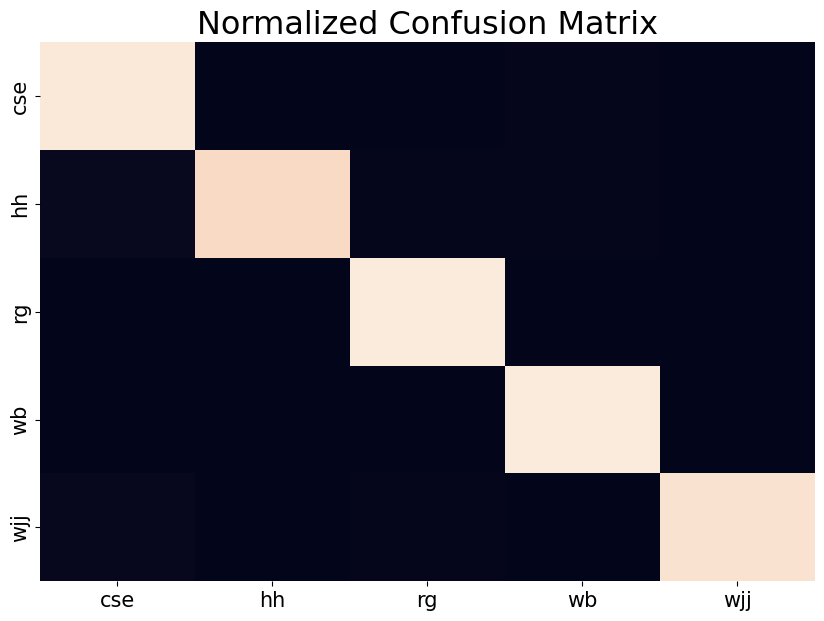

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [21]:
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.applications.resnet_v2 import preprocess_input
def printmd(string):
    display(string)
class_dictionary = test_images.class_indices
model = load_model('checkpoint/epoch-9-val_loss-0.0820-val_acc-0.9801.keras')
IMAGE_SIZE    = (150,150)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


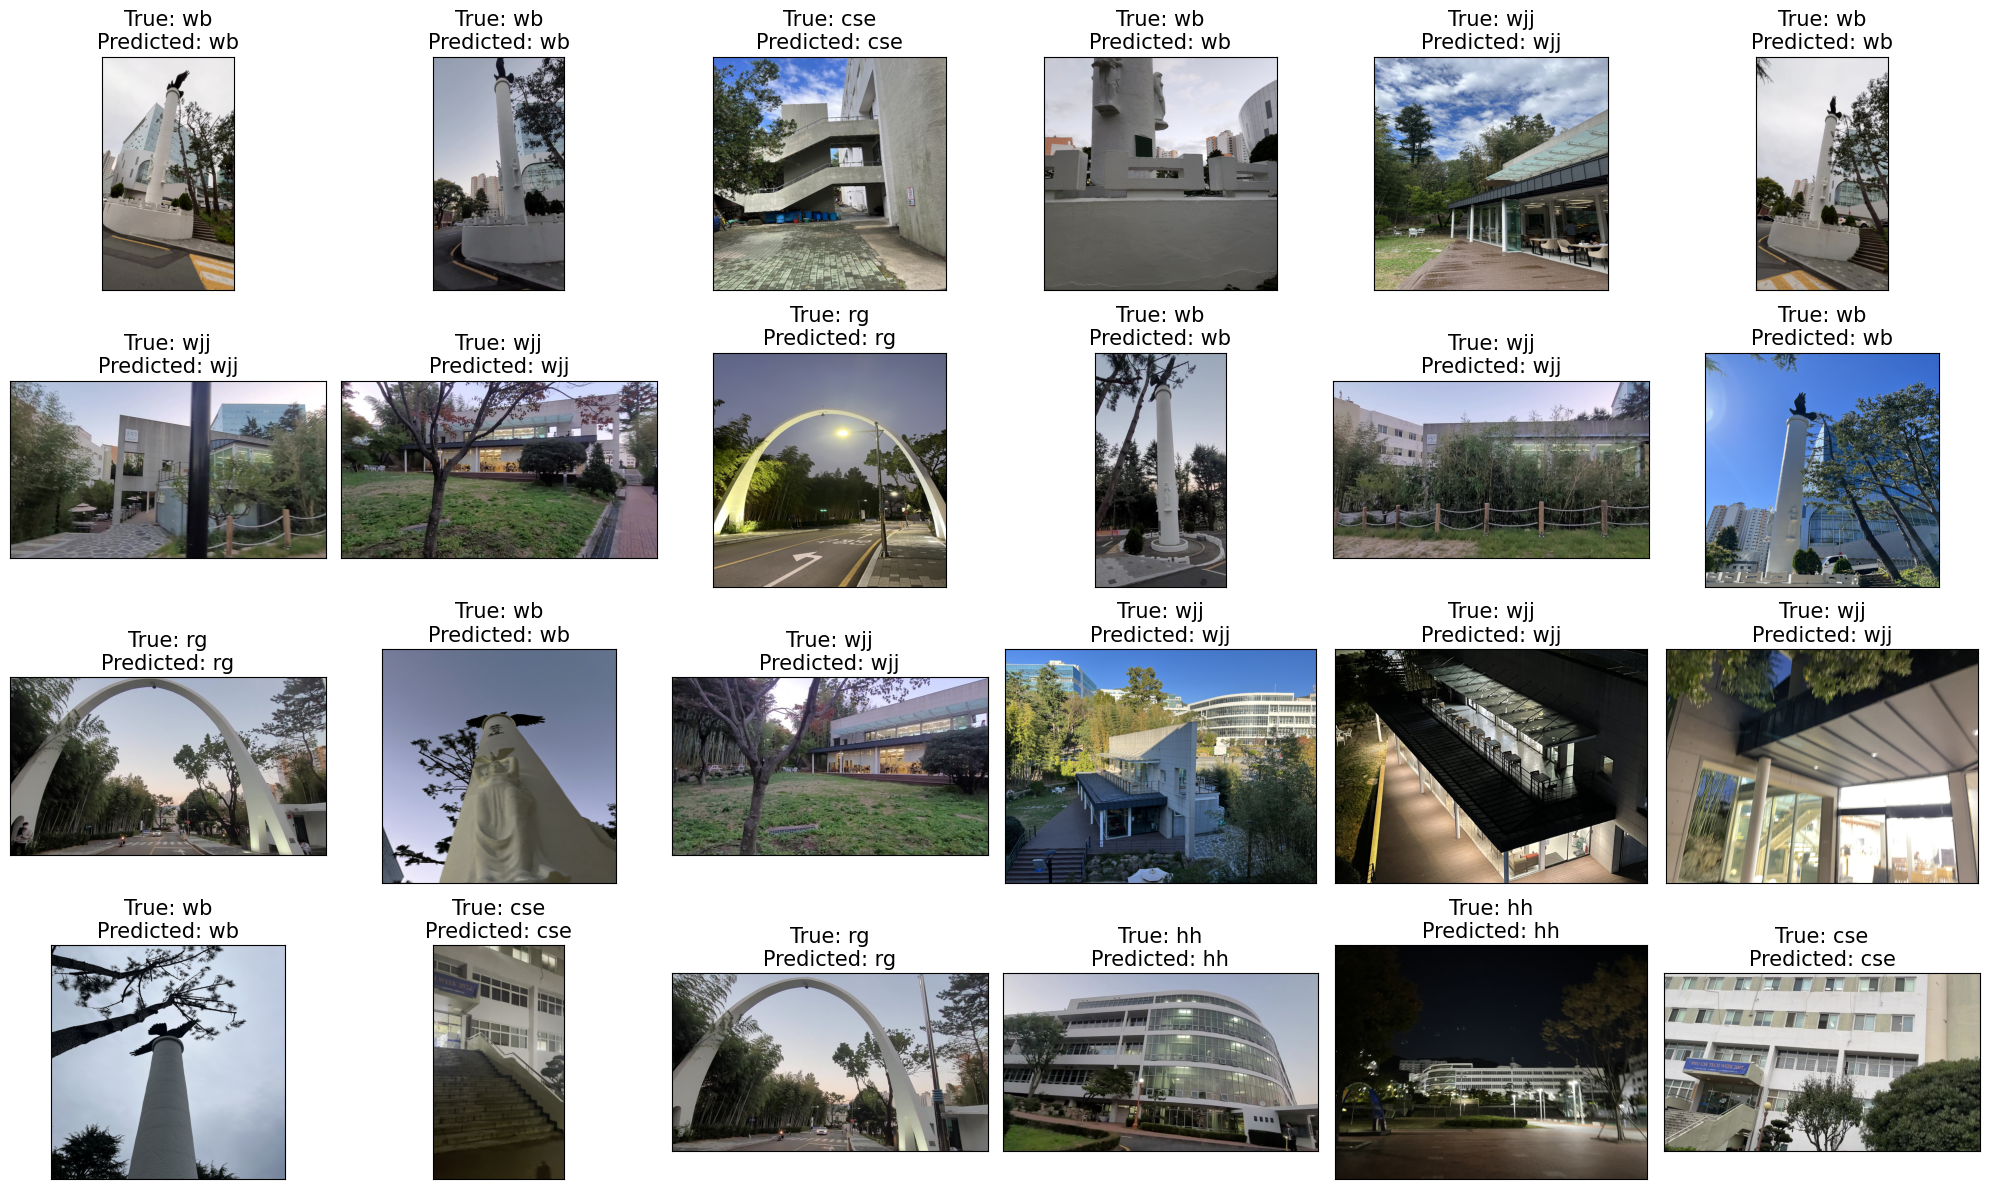

In [22]:

# 여러 이미지 테스트
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.File_path.iloc[i]))
    test_image = image.load_img(test_df.iloc[i, 0]
                            ,target_size =IMAGE_SIZE )
    test_image = image.img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    test_image = preprocess_input(test_image)
    prediction = model.predict(test_image)
    df = pd.DataFrame({'pred':prediction[0]})
    df = df.sort_values(by='pred', ascending=False, na_position='first')
    for x in class_dictionary:
      if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
        ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {x}", fontsize = 15)
plt.tight_layout()
plt.show()

In [9]:
import time

# 사전 구현된 모델 가져오기
# 모델 중 가장 성능이 좋은 모델을 찾아 개선

models = {
    # "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    # "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    # "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    # "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    # "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    # "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    # "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,val_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(150, 150, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    # 라벨 개수가 5개이기 때문에 Dencs도 5로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = time.perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,validation_steps=5,epochs=1,verbose=1)
    
    # 학습시간과 val_accuracy 저장
    duration = time.perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 4525 validated image filenames belonging to 5 classes.
Found 503 validated image filenames belonging to 5 classes.
Found 564 validated image filenames belonging to 5 classes.


I0000 00:00:1733458944.343509 2100742 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1077 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:23:00.0, compute capability: 8.6


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733458967.622229 2102538 service.cc:148] XLA service 0x7fbd100031e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733458967.622271 2102538 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-12-06 13:22:47.955062: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733458970.045141 2102538 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-06 13:22:51.420792: I external

 1/71 ━━━━━━━━━━━━━━━━━━━━ 21:43 19s/step - accuracy: 0.1562 - loss: 1.7784

I0000 00:00:1733458975.516786 2102538 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/71 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - accuracy: 0.5834 - loss: 1.0392

2024-12-06 13:23:17.446522: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14461_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:23:17.591389: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14461', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:23:17.596523: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14461_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:23:17.655690: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14728', 8 bytes spill stores, 8 bytes spill loads

2024-12-06 13:23:17.703944: I external/local_xla/xla/stream_

71/71 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7602 - loss: 0.6254 - val_accuracy: 0.9187 - val_loss: 0.2038
ResNet152V2          trained in 120.58 sec
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


2024-12-06 13:24:47.265010: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


71/71 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.2434 - loss: 1.5914 - val_accuracy: 0.3000 - val_loss: 1.4970
ResNet50             trained in 102.4 sec
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7679 - loss: 0.6160 - val_accuracy: 0.9094 - val_loss: 0.2904
ResNet50V2           trained in 99.46 sec
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


2024-12-06 13:28:13.575788: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1295', 440 bytes spill stores, 440 bytes spill loads

2024-12-06 13:28:13.598893: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1295', 496 bytes spill stores, 496 bytes spill loads

2024-12-06 13:28:13.630387: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.13MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-06 13:28:13.630443: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.13MiB with freed_by_count=0. The caller indicates that this

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2100742/3268033243.py", line 61, in <module>

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.48 = (f32[64,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,150,150]{3,2,1,0} %bitcast.1325, f32[64,3,3,3]{3,2,1,0} %bitcast.1327, f32[64]{0} %arg3.4), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/block1_conv1_1/convolution" source_file="/home/team110/miniconda3/envs/tensorflow/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: INTERNAL: All algorithms tried for (f32[64,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,150,150]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} failed. Falling back to default algorithm.  Per-algorithm errors:
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16912256 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16912256 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16912256 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16817152 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777324 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 402704144 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 402704144 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 402704144 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 54935552 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_69908]

In [ ]:
# test데이터로 모델 성능 예측
from sklearn.metrics import accuracy_score
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['accuracy'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['accuracy'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results